---
title: "Módulo: Aprendizaje Automático Aplicado en la Simulación espacio temporal de Suelo Urbano de la Ciudad de Morelia"
format:
  html:
    toc: true
    toc-expand: 2
    toc-location: left
    code-fold: True
    html-math-method: katex
---

# Introducción

Un modelo de simulación de cobertura de suelo es un modelo computacional spacio-temporal basado en estadística y matemáticas, trata de predecir como algun tipo de cobertura se distribuye en esl espacio geográfico en el tiempo.

Estos modelos son muy útiles y son utilizados en la planificación urbana, la gestión de recursos naturales, la conservación del medio ambiente, la agricultura, entre otros. El esquema general de un modelo de simulación de cobertura urbana se muestra en #fig-modelo @fig-modelo

![Modelo Simulacion](figuras/modelo_conceptual_land_change_sim.png){#fig-modelo}


Este esquema esta compuesto de varias partes:

1. El módulo que recibe los mapas transformados en variables dependientes e independientes.
2. El modelo espacial de idoneidad que indica la suceptibilidad de las caracteristicas del terreno para experimentar urbanización.
3. Un modelo temporal de pronóstico de incremento en la cantidad de cobertura urbana.
4. Un método de localizacion que simula cantidad de cobertura pronosticada.
4. Una simulación de la urbanización considerando el modelo espacial y temporal
En este módulo aprenderemos a generar y comparar dos modelos de aprendizaje automático: La regresión Lineal y Regresión con una Red Neuronal de propagación hacia adelante. Estos dos modelos operan en el espacio geográfico para estimar la idoneidad.

Aunque es muy complicado predecir las tendencias espaciales de urbanización, es posible usar estos modelos como referencia.

Este módulo abarca los siguientes temas:

* Aprenderemos teoría básica sobre la regresión lineal
* Funcionamiento básico de las redes neuronales.
* Describiremos el problema de regresión a resolver.
* Cargaremos y visualizaremos los datos
* Construiremos el conjunto de entrenamiento y prueba
* Construiremos dos modelos de regresión Lineal
* Compararemos los modelos en términos de la matriz de confusión, Correlación de Mathews, Area Bajo la curva
* Compararemos los dos mapas de idoneidad

**Pre-requisitos:**

Módulo de Procesamiento de mapas GrassGis.
Módulo de aprendizaje profundo sección redes neuronales profundas de propagación hacia adelante



# Regresión Logística

La regresión logística es un algoritmo de aprendizaje automático que resuelve un problema de clasificación binaria prediciendo la probabilidad de que un vector de características sea clasificado en una clase.

Para esto, la regresión logística se entrena con un conjunto de datos de la forma $\mathbf{D} = \{\mathbf{x}_i, y_i  \}_{i=0}^{m-1}$. Donde $\mathbf{x}_i$ es un vector de características y $y_i \in \{0,1\}$ es una variable binaria que representa la clasificación del vector de características. La regresión logística se define como la siguente Ecuación:


$$\hat{y}_i = f_{reglog}(\mathbf{x}_i| \theta)$$

, y $\mathbf{x} = \{x_0, x_1, \dots, x_{m-1} \}$ es el vector de características y $\hat{y} \in [0, 1]$ es un escalar que indica la probabilidad.

Dónde $\theta = \{w_0, w_1, \dots, w_{n-1}, b\}$ es el vector de parámetros optimizables.

$$f_{reglog}(\mathbf{x}_i|\theta) = \sigma(\mathbf{w}^T \mathbf{x}_i + b) $$

y $\sigma$ está definido por $\sigma(z) = \frac{1}{1+e^{-z}}$

El modelo puede representarse por medio de un grafo direccionado @fig-reglog

![Modelo regresion logistica](figuras/reglog.svg){#fig-reglog}



Para entrenar el modelo, se requiere una función de costo que nos indique que tan cerca está el modelo $f_{reglog}$ del ajuste deseado. Esta función de costo puede ser la log Verosimilitud $LL(\theta)$

$$LL(\theta) = \sum_{i=0}^{m-1} (y_i \text{ log } \sigma(\mathbf{w}^T \mathbf{x}_i+b) + (1-y_i) \text{ log } [1-\sigma(\mathbf{w}^T \mathbf{x}_i+b)])$$

La cual se obtiene de la función de probabilidad de Bernoulli como función de verosimilitud.

$$L(\theta) = \prod_{i=0}^{m-1}\sigma(\mathbf{w}^T \mathbf{x}_i + b )^{y_i} [1-\sigma(\mathbf{w}^T \mathbf{x}_i + b)]^{(1-y_i)} $$


Esta expresión $LL(\theta)$ la usaremos para construir nuestra función objetivo a maximizar. 

$$\mathbf{w},b = \underset{\theta = \{\mathbf{w},b\}}{\text{arg max }} LL(\theta)$$


Esta nos indica que quremos encontrar aquellos parámetros $\theta$ que nos produzcan el mayor valor posible de esta función.





# Red Neuronal Multi Capa

Una red neuronal Artificial es un modelo matemático inspirado en el comportamiento biológico de las neuronas y en la estructura del cerebro. 
Las ideas y descubrimientos en neurociencias sirven como inspiración en la construcción de modelos computacionales capaces de resolver problemas complejos de clasificación y regresión.

Los perceptrones estan formados por:


* La Entrada. Es el vector $\mathbf{x}_i$ de características.
* Los Pesos. Indican la importancia de cada elemento del vector $\mathbf{x}_i$ de entrada. Los pesos forman parte de los parámetros optimizables.
* Función de activación. Es una función no lineal $\phi(\cdot)$. Hay varias funciones de activación, una de ellas es la función sigmoidal utilizada por la regresión logística.


$$f_{perceptron}(\mathbf{x}_i|\theta) = \phi(\mathbf{w}^T \mathbf{x}_i + b) $$


Estos perceptrones simples estan interconectados entre si dando lugar a diferentes tipos de arquitecturas en redes neuronales.


Una Red Neuronal Multi-Capa con propagación hacia adelante tiene la característica de tener sus neuronas organizadas por capas y cada capa se limita a transferir la información hacia adelante desde la capa de entrada hasta la capa de salida. Tal como se muestra en la figura @fig-redneuronal.



![Modelo MLP](figuras/redneuronal.svg){#fig-redneuronal}


# Aplicación: Modelo espacio temporal de cambio de uso de suelo.

Leemos la base de datos.

Tenemos dos conjuntos de datos, uno de entrenameinto y otro de validación.

Ambos conjuntos tienen la misma estructura.


El primer conjunto de datos contiene las características de suelo en el intervalo 2000 al 2018.


La base de datos incluye información sobre las coordenadas cartesianas (lat, lon )en epsg:4232 (Liga a un módulo introductorio a GIS), 








In [7]:
import os
import sys  
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import importlib
import seaborn as sns
import itertools as it
from shapely.geometry import Point, Polygon

root = os.getcwd() + "/.."
sys.path.insert(0, root)
crs_m = 'epsg:4326'

In [8]:
def graficarVariablesEspaciales(data):
    
    geometry = [Point(xy) for xy in zip(data["lat"], data["lon"])]
    geodata = gpd.GeoDataFrame(data, crs = crs_m, geometry = geometry)
    columns = data.columns

    fig, axs = plt.subplots(3, 3, figsize = (10, 10))
    for ix, c in enumerate(it.product(np.arange(3), repeat = 2)):

        i = c[0]
        j = c[1]

        column_name = columns[3+ix]
        geodata.plot(ax = axs[i, j], figsize = (20/4, 15/4), column = geodata[column_name], cmap = "viridis_r", legend = True, markersize = 0.01)
        
        
    plt.tight_layout()
    plt.show()
    
    
def plotParesdeScatterPlots(data):
    
    sns.set_theme(style = "ticks")
    data = data.sample(frac=0.001)
    sns.pairplot(data[data.columns[3:]], hue = "incremento_urbano")
        
    



In [9]:
#Independent Spatial Variables
X_train = pd.read_csv("../databases/morelia/processed/Morelia_train_X.csv", header = 0)
Y_train = pd.read_csv("../databases/morelia/processed/Morelia_train_Y.csv", header = 0)




Esta tabla tiene las caracteristicas de cada coordenada que representa una región de $30m \times 30m$. 

* ixs es el índice que contiene valores unicos conformados por las coordenadas de latitud y longitus.
* lat es la latitud
* lon es la longitud
* pendiente, es la pendiente topográfica en esa coordenada
* dist_anps. Es la distancia mas cercana en linea recta de la coordenada (lat,lon) a la cobertura de areas naturales protegidas en el año 2000
* dist_agua. Es la distancia mas cercana en linea recta de la coordenada (lat,lon) a la cobertura de cuerpos de agua en el año 2000
* dist_centro. Es la distancia mas cercana en linea recta de la coordenada (lat,lon) al centro Histórico de la ciudad de Morelia
* dist_carreteras: es la distancia mas corta a la carretarea mas cercana desde la coordenada (lat,lon). en el año 2018
* costo: es el costo mínimo de traslado en mínutos desde la coordenada (lat, lon) al centro de la ciudad considerando trayectos en carretera.


De esta información, cada vector $\mathbf{x}_i$ tendrá la información:

* $x_0$: pendiente
* $x_1$: distancia a áreas naturales protegidas
* $x_2$: distancia a cuerpos de agua
* $x_3$: distancia a vegetacion
* $x_4$: distancia acobertura urbana
* $x_5$: Distancia al centro de la ciudad.

In [10]:
X_train.head()

ixs            lat           lon  \
0  (261048.43444431, 2197800.28581634)  261048.434444  2.197800e+06   
1  (260868.45322116, 2197770.28111502)  260868.453221  2.197770e+06   
2  (260898.45009169, 2197770.28111502)  260898.450092  2.197770e+06   
3  (260928.44696221, 2197770.28111502)  260928.446962  2.197770e+06   
4  (260958.44383274, 2197770.28111502)  260958.443833  2.197770e+06   

   pendiente     dist_anps   dist_agua  dist_vegetacion  dist_urbano  \
0   6.379370  19680.839119  212.111013      1248.803589  3447.554694   
1   4.520227  19775.810448   29.996871      1073.256704  3330.856765   
2   0.000000  19756.121616   59.993741      1100.167146  3345.547238   
3   6.379370  19736.458733   89.990612      1127.233414  3360.441263   
4   5.710593  19716.821879  119.987482      1154.444548  3375.536145   

    dist_centro  dist_carreteras      costo  
0  19913.443890      3636.319906  99.051445  
1  19969.945500      3530.974224  97.796815  
2  19955.995077      3543.566054  97.945904  
3  19942.080016      3556.366322  98.094994  
4  19928.200391      3569.372785  98.244083

In [11]:
Y_train.head()

ixs            lat           lon  \
0  (261048.43444431, 2197800.28581634)  261048.434444  2.197800e+06   
1  (260868.45322116, 2197770.28111502)  260868.453221  2.197770e+06   
2  (260898.45009169, 2197770.28111502)  260898.450092  2.197770e+06   
3  (260928.44696221, 2197770.28111502)  260928.446962  2.197770e+06   
4  (260958.44383274, 2197770.28111502)  260958.443833  2.197770e+06   

   incremento_urbano  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0

In [12]:
X_train["incremento_urbano"] = Y_train["incremento_urbano"]

La información del incremento urbano esta dada por la Tabla, la cual contiene al igual que la tabla anterior las coordenadas lat,lon en la columna ixs, lat, lon e incremento urbano que es la observación del incremento urbano en el intervalo de tiempo del año 2000 al 2018

In [13]:
X_valid = pd.read_csv("../databases/morelia/processed/Morelia_validation_X.csv", header = 0)
Y_valid = pd.read_csv("../databases/morelia/processed/Morelia_validation_Y.csv", header = 0)

## Estructura de los datos

La estructura es la misma para los datos de validación que estan conforomados por las características observadas en el año 2018 y relacionadas con el incremento de cobertura de suelo urbano en 2021

In [14]:
X_valid.head()

ixs            lat           lon  \
0  (261048.43444431, 2197800.28581634)  261048.434444  2.197800e+06   
1  (260868.45322116, 2197770.28111502)  260868.453221  2.197770e+06   
2  (260898.45009169, 2197770.28111502)  260898.450092  2.197770e+06   
3  (260928.44696221, 2197770.28111502)  260928.446962  2.197770e+06   
4  (260958.44383274, 2197770.28111502)  260958.443833  2.197770e+06   

   pendiente     dist_anps   dist_agua  dist_vegetacion  dist_urbano  \
0   6.379370  19680.839119  212.111013      1248.803589  3447.554694   
1   4.520227  19775.810448   29.996871      1073.256704  3330.856765   
2   0.000000  19756.121616   59.993741      1100.167146  3345.547238   
3   6.379370  19736.458733   89.990612      1127.233414  3360.441263   
4   5.710593  19716.821879  119.987482      1154.444548  3375.536145   

    dist_centro  dist_carreteras      costo  
0  19913.443890       997.266806  44.300857  
1  19969.945500      1106.352244  45.742605  
2  19955.995077      1083.755330  45.405656  
3  19942.080016      1061.525113  45.146802  
4  19928.200391      1039.685116  44.786802

In [15]:
Y_valid.head()

ixs            lat           lon  \
0  (261048.43444431, 2197800.28581634)  261048.434444  2.197800e+06   
1  (260868.45322116, 2197770.28111502)  260868.453221  2.197770e+06   
2  (260898.45009169, 2197770.28111502)  260898.450092  2.197770e+06   
3  (260928.44696221, 2197770.28111502)  260928.446962  2.197770e+06   
4  (260958.44383274, 2197770.28111502)  260958.443833  2.197770e+06   

   incremento_urbano  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0

In [16]:
X_valid["incremento_urbano"] = Y_valid["incremento_urbano"]
X_valid.head()

ixs            lat           lon  \
0  (261048.43444431, 2197800.28581634)  261048.434444  2.197800e+06   
1  (260868.45322116, 2197770.28111502)  260868.453221  2.197770e+06   
2  (260898.45009169, 2197770.28111502)  260898.450092  2.197770e+06   
3  (260928.44696221, 2197770.28111502)  260928.446962  2.197770e+06   
4  (260958.44383274, 2197770.28111502)  260958.443833  2.197770e+06   

   pendiente     dist_anps   dist_agua  dist_vegetacion  dist_urbano  \
0   6.379370  19680.839119  212.111013      1248.803589  3447.554694   
1   4.520227  19775.810448   29.996871      1073.256704  3330.856765   
2   0.000000  19756.121616   59.993741      1100.167146  3345.547238   
3   6.379370  19736.458733   89.990612      1127.233414  3360.441263   
4   5.710593  19716.821879  119.987482      1154.444548  3375.536145   

    dist_centro  dist_carreteras      costo  incremento_urbano  
0  19913.443890       997.266806  44.300857                  0  
1  19969.945500      1106.352244  45.742605                  0  
2  19955.995077      1083.755330  45.405656                  0  
3  19942.080016      1061.525113  45.146802                  0  
4  19928.200391      1039.685116  44.786802                  0

Enseguida analizamos como se ven estas variables en el espacio del conjunto de entrenamiento.




In [17]:
#graficarVariablesEspaciales(X_train)

Similarmente, Visualizamos el conjunto de validación

In [18]:
X_valid["incremento_urbano"] = Y_valid["incremento_urbano"]
X_valid.head()

ixs            lat           lon  \
0  (261048.43444431, 2197800.28581634)  261048.434444  2.197800e+06   
1  (260868.45322116, 2197770.28111502)  260868.453221  2.197770e+06   
2  (260898.45009169, 2197770.28111502)  260898.450092  2.197770e+06   
3  (260928.44696221, 2197770.28111502)  260928.446962  2.197770e+06   
4  (260958.44383274, 2197770.28111502)  260958.443833  2.197770e+06   

   pendiente     dist_anps   dist_agua  dist_vegetacion  dist_urbano  \
0   6.379370  19680.839119  212.111013      1248.803589  3447.554694   
1   4.520227  19775.810448   29.996871      1073.256704  3330.856765   
2   0.000000  19756.121616   59.993741      1100.167146  3345.547238   
3   6.379370  19736.458733   89.990612      1127.233414  3360.441263   
4   5.710593  19716.821879  119.987482      1154.444548  3375.536145   

    dist_centro  dist_carreteras      costo  incremento_urbano  
0  19913.443890       997.266806  44.300857                  0  
1  19969.945500      1106.352244  45.742605                  0  
2  19955.995077      1083.755330  45.405656                  0  
3  19942.080016      1061.525113  45.146802                  0  
4  19928.200391      1039.685116  44.786802                  0

In [19]:
#graficarVariablesEspaciales(X_valid)
    
    
    
    

## Conociendo los Datos: Visualización de los datos.


Para explorar los datos inicialmente utilizaremos un mapa de disperción mostrando una muestra de 500 vectores que muestra una idea de a distribución de los datos.

Como ejemplo, se muestra una gráfica en donde se analiza la relacion de la distancia a carretares con el costo de traslado al centro de la ciudad en el año 20018 con la observación el incremento urbano del 2000 al 2018

<Axes: xlabel='dist_carreteras', ylabel='costo'>

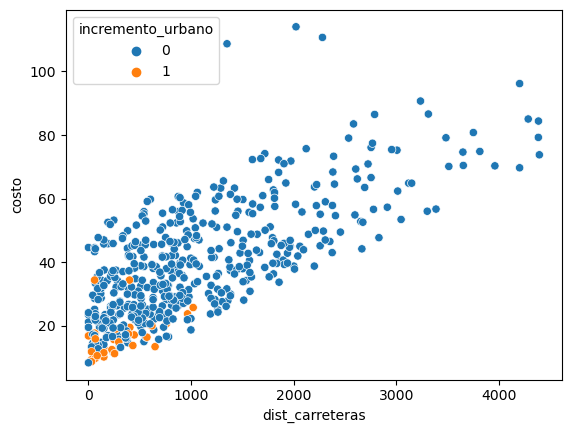

In [20]:
ix = np.random.randint(0, len(X_train), 500)
sns.scatterplot(data = X_train.iloc[ix], x = "dist_carreteras", y = "costo", hue = "incremento_urbano")

El resto de variables se ven en el siguiente análisis de pares de variables en gráficas de dispersión.

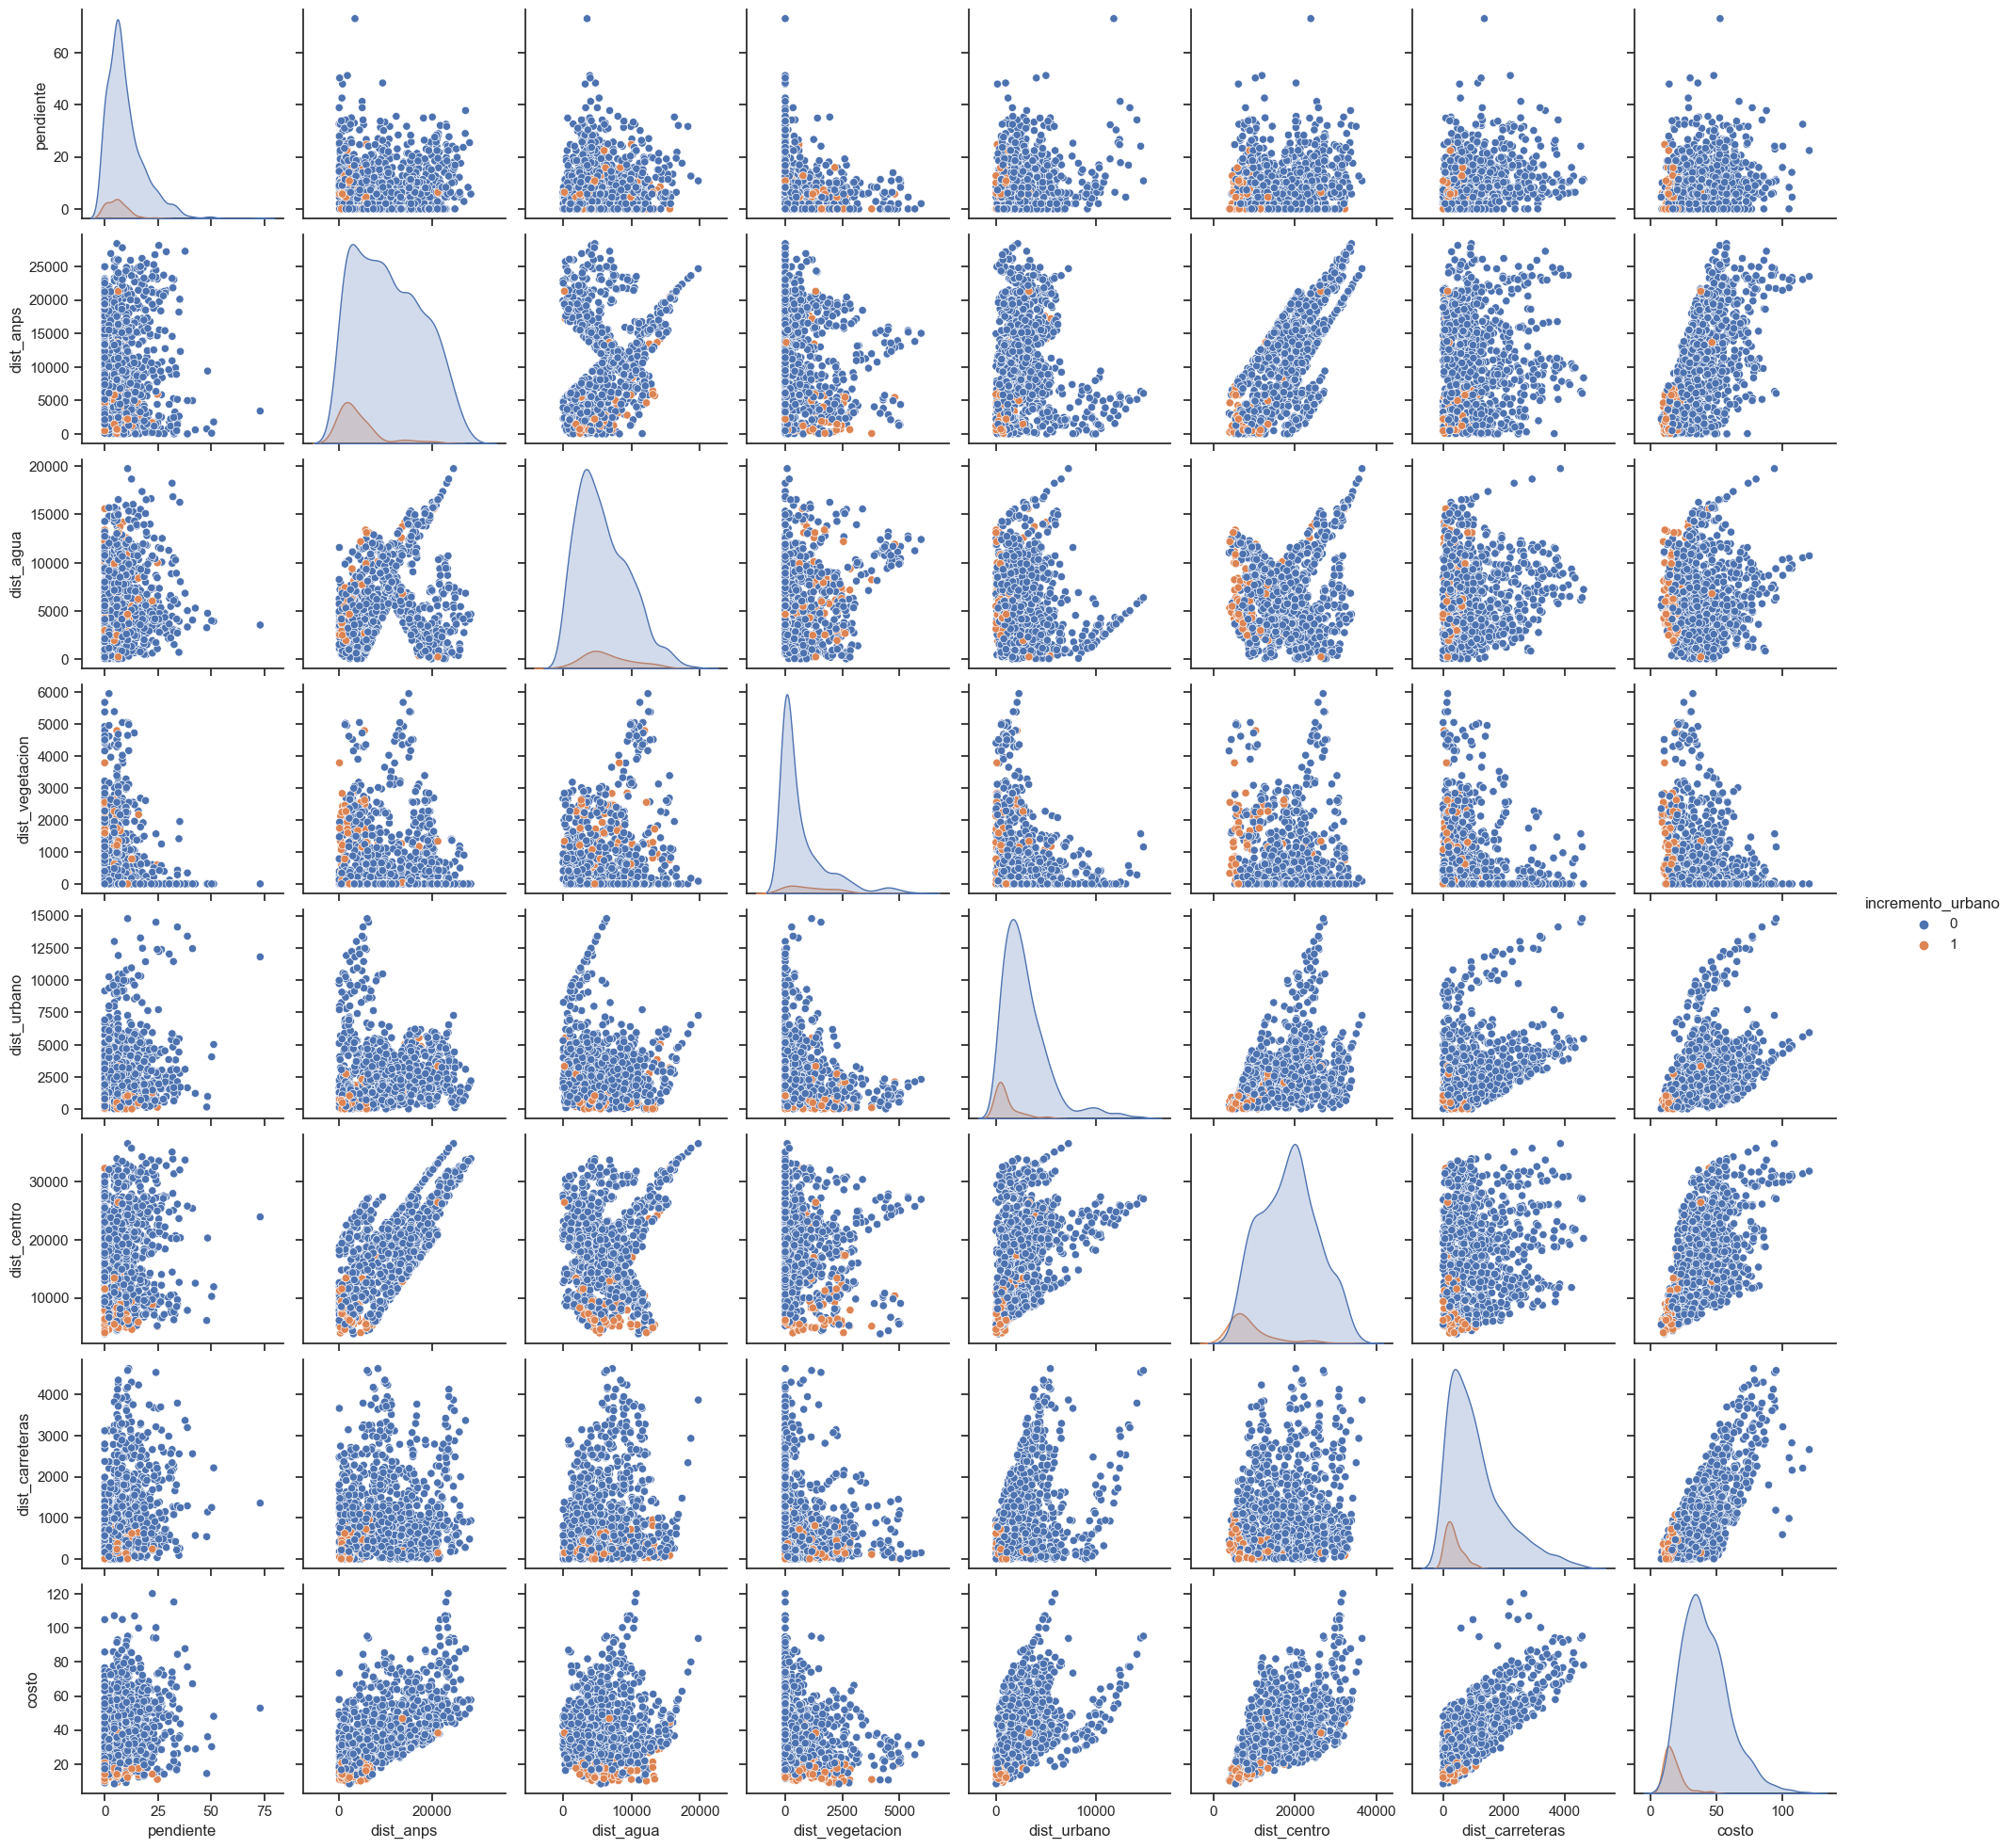

In [21]:
plotParesdeScatterPlots(X_train)

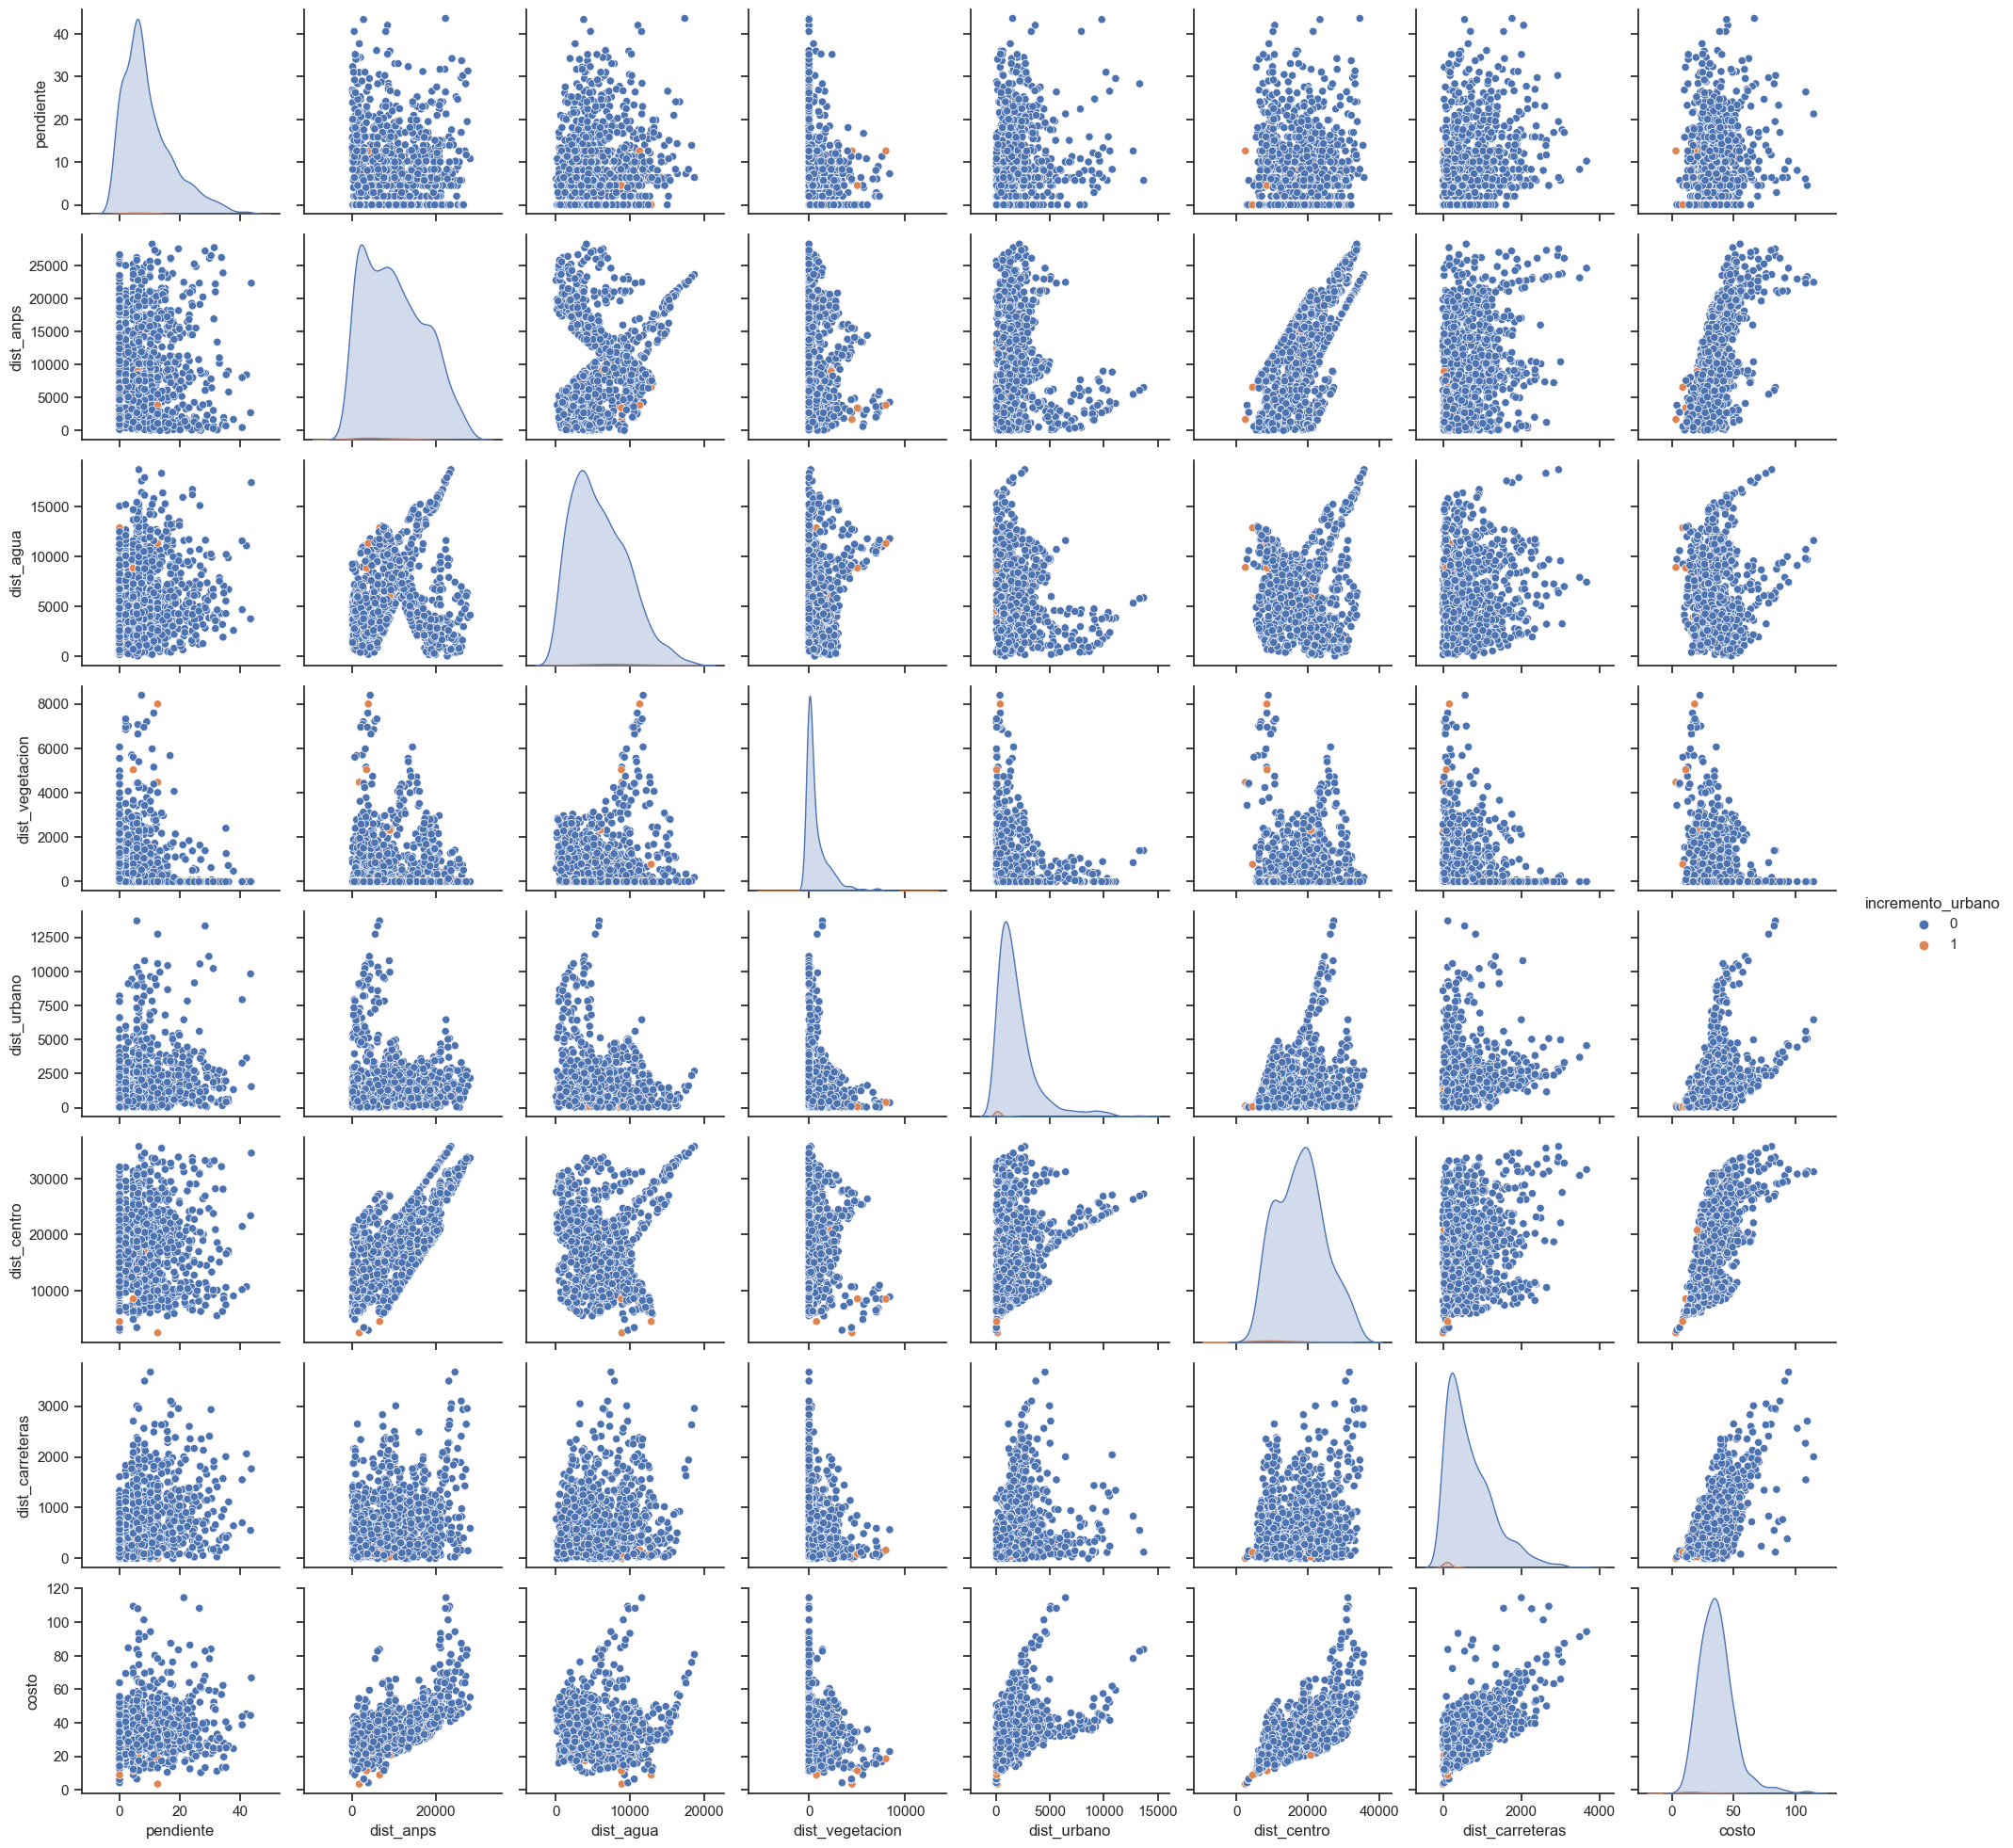

In [22]:
plotParesdeScatterPlots(X_valid)


Podemos apreciar de primer momento que la urbanización esta concentrada en valores bajos de casi todas las variables.

El número de vectores que presencian cambio es muy poco en relacion a la totalidad de los datos.

Los datos están muy desbalanceados.

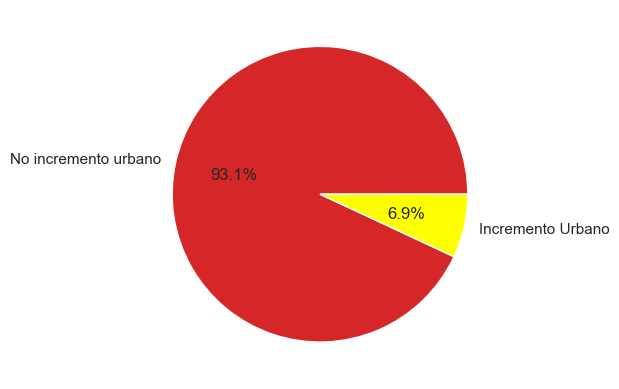

In [23]:
fig, ax = plt.subplots()
labels = ['No incremento urbano', 'Incremento Urbano']
sizes = [len(Y_train["incremento_urbano"]), np.sum(Y_train["incremento_urbano"])]
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['tab:red', 'yellow'])
plt.show()


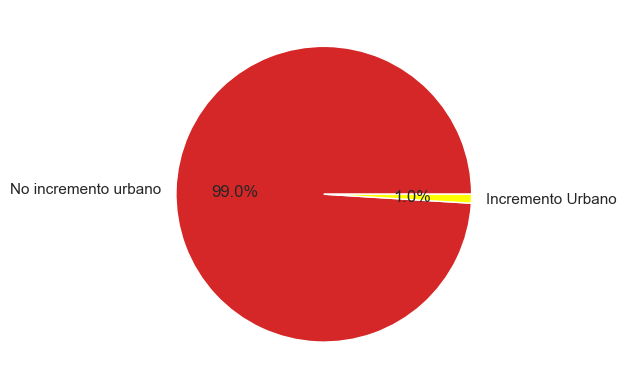

In [24]:
fig, ax = plt.subplots()
labels = ['No incremento urbano', 'Incremento Urbano']
sizes = [len(Y_valid["incremento_urbano"]), np.sum(Y_valid["incremento_urbano"])]
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['tab:red', 'yellow'])
plt.show()


# Planteamiento de una estrategia para resolverlo


**Todos los modelos son errados, pero unos son mas útiles que otros** - *George Edward Pelham Bo*

La búsqueda de un modelo que nos de información útil sobre el futuro no es una tarea sencilla.

Una estrategia para seleccionar un modelo es tener un modelo base. Este modelo debe ser intuitivo, sencillo de entender y debe servir como primera hipótesis.

En este caso proponemos un modelo base $f_{\text{urbano}}$ que toma como variable independiente la distancia a un centro urbano.




In [25]:
### Modelo Base

In [26]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler()

In [27]:
xtrain = X_train[X_train.columns[3:3+8]].to_numpy()
ytrain = X_train[X_train.columns[3+8]].to_numpy()

xvalid = X_valid[X_valid.columns[3:3+8]].to_numpy()
yvalid = X_valid[X_valid.columns[3+8]].to_numpy()

In [37]:
classifier = MLPClassifier(hidden_layer_sizes = (1), max_iter = 1000, 
                           activation = 'identity', solver = 'adam',
                           random_state = 1)

In [38]:
X_train_resampled, y_train_resampled = undersampler.fit_resample(xtrain, ytrain)

In [39]:
M = classifier.fit(X_train_resampled, y_train_resampled)

In [40]:
#Model 1
ytrain_hat = M.predict_proba(xtrain)[:,1]
yvalid_hat = M.predict_proba(xvalid)[:,1]
ytrain_hat_c = M.predict(xtrain)
yvalid_hat_c = M.predict(xvalid)


In [41]:
q = np.sum(yvalid)
tr = np.sort(yvalid_hat)[::-1][q]


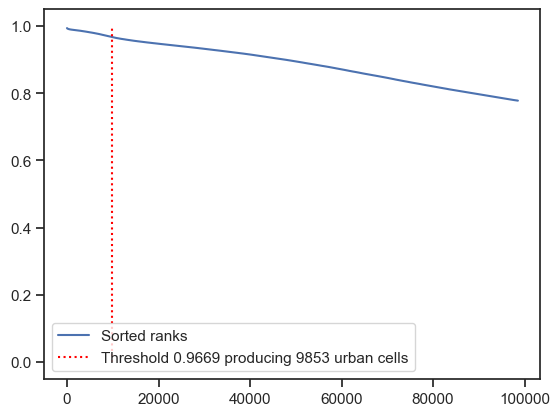

In [42]:
plt.plot(np.sort(yvalid_hat)[::-1][:q*10], label = "Sorted ranks")
plt.vlines(x = q, ymin = 0, ymax = 1, color = "red",linestyles='dotted', label = "Threshold {tr} producing {q} urban cells".format(tr=np.round(tr,4), q=q))
plt.legend()
plt.show()


In [43]:
# model a
fprlogtrain, tprlogtrain, _ = metrics.roc_curve(ytrain,  ytrain_hat)
fprlogvalid, tprlogvalid, _ = metrics.roc_curve(yvalid,  yvalid_hat)


In [44]:
X_valid["probability_linear_classification"] = yvalid_hat

In [45]:
Y = np.copy(X_valid["incremento_urbano"].to_numpy().ravel())
y = (yvalid_hat>tr)*1

In [46]:
tn, fp, fn, tp  = metrics.confusion_matrix(Y,y).ravel()


In [47]:
metrics.matthews_corrcoef(Y, y)

0.22458862242904726

In [48]:
X_valid["linear_classification"] = 1*(yvalid_hat>tr)

In [49]:
X_valid[["incremento_urbano", "linear_classification"]]

incremento_urbano  linear_classification
0                        0                      0
1                        0                      0
2                        0                      0
3                        0                      0
4                        0                      0
...                    ...                    ...
1001990                  0                      0
1001991                  0                      0
1001992                  0                      0
1001993                  0                      0
1001994                  0                      0

[1001995 rows x 2 columns]

In [50]:
X_valid.loc[(X_valid["incremento_urbano"]==1) & (X_valid["linear_classification"]==1),"color"] = "TP"
X_valid.loc[(X_valid["incremento_urbano"]==0) & (X_valid["linear_classification"]==0),"color"] = "TN"
X_valid.loc[(X_valid["incremento_urbano"]==1) & (X_valid["linear_classification"]==0),"color"] = "FN"
X_valid.loc[(X_valid["incremento_urbano"]==0) & (X_valid["linear_classification"]==1),"color"] = "FP"

In [51]:
pointsPalette = {'TP': 'red',
                 'TN': 'gray', 
                 'FP': 'yellow', 
                 'FN': 'blue' 
                }

In [52]:
from matplotlib.colors import ListedColormap


# [R,G,B,Alpha]
amarillo = np.array([1, 1, 0, 1])
azul = np.array([0, 0, 1, 1])
gris = np.array([0.5, 0.5, 0.5, 1])
rojo = np.array([1, 0, 0, 1])


paletaConfusion = np.zeros((4,4))
paletaConfusion[:1, :] = amarillo
paletaConfusion[1:2, :] = azul
paletaConfusion[3:4, :] = rojo
paletaConfusion[2:3, :] = gris

mapaDeColores = ListedColormap(paletaConfusion)


<Axes: >

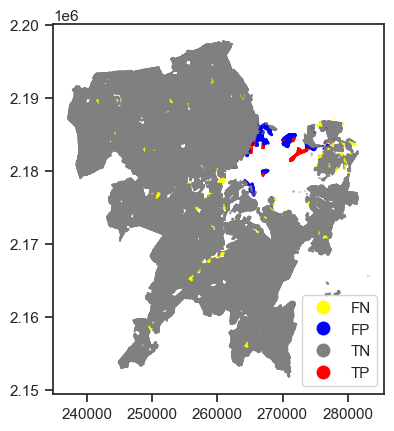

In [53]:

#este tiene que ser geodata
data = X_valid
geometry = [Point(xy) for xy in zip(data["lat"], data["lon"])]
geodata = gpd.GeoDataFrame(data, crs = crs_m, geometry = geometry)
geodata.plot( column = X_valid["color"], cmap = mapaDeColores, legend = True, markersize = 0.01)


In [54]:
#plt.bar(X_train.columns[3:3+8], classifier.coefs_[0].flatten(), color = "tab:red")
#plt.xticks(rotation = 45)
#plt.show()


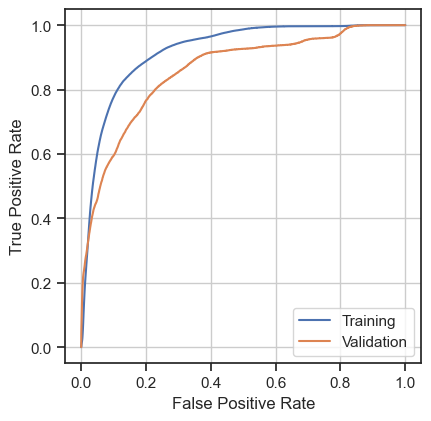

In [55]:
plt.figure(figsize = (4.6, 4.6))
plt.plot(fprlogtrain, tprlogtrain, label = "Training")
plt.plot(fprlogvalid, tprlogvalid, label = "Validation")
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()